# 토이 데이터 생성

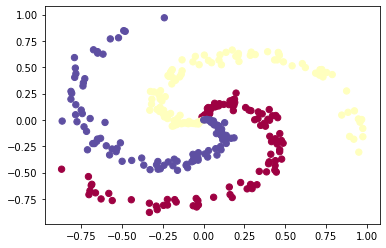

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 100   # number of points per class
D = 2     # dimensionality
K = 3     # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

# 함수 정의

각 신경망 층에서 사용할 함수들을 정의합니다.

In [2]:
def affine_forward(x, w, b):
    out = np.dot(x, w) + b    
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    x, w, b = cache
    db = np.sum(dout, axis=0)
    dw = np.dot(x.T, dout)
    dx = np.dot(dout, w.T)
    return dx, dw, db

def relu_forward(x):
    out = np.maximum(x, 0)
    cache = x
    return out, cache

def relu_backward(dout, cache):
    dout[cache<0] = 0
    return dout

def softmax(x):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    exp_score = np.exp(shifted_logits)
    probs = exp_score / np.sum(exp_score, axis=1, keepdims=True)
    return probs

def cross_entropy_loss(probs, y):
    N = probs.shape[0]
    loss = -np.log(probs[range(N), y])
    total_loss = np.sum(loss) / N
    dx = probs
    dx[range(N), y] -= 1
    dx /= N
    return total_loss, dx

# 모델 만들기

위에서 만든 함수를 차례대로 부르는 게 거의 전부입니다.

In [11]:
class TwoLayerNet():
    def __init__(self, input_dim, hidden_dim=10, num_classes=10, weight_scale=1):

        self.params = {}
        self.grads = {}
        self.params['W1'] = np.random.randn(input_dim, hidden_dim) * weight_scale
        self.params['W2'] = np.random.randn(hidden_dim, num_classes) * weight_scale
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['b2'] = np.zeros(num_classes)
        
    def forward(self, X, y=None):
        Z1, cache1 = affine_forward(X, self.params['W1'], self.params['b1'])
        A1, cache2 = relu_forward(Z1)
        Z2, cache3 = affine_forward(A1, self.params['W2'], self.params['b2'])
        probs = softmax(Z2)
        if y is None:
            return probs
        loss, dZ2 = cross_entropy_loss(probs, y)
        self.cache = (cache1, cache2, cache3, dZ2)
        return loss
    
    def backward(self):
        (cache1, cache2, cache3, dZ2) = self.cache
        dA1, self.grads['W2'], self.grads['b2'] = affine_backward(dZ2, cache3)
        dZ1 = relu_backward(dA1, cache2)
        _, self.grads['W1'], self.grads['b1'] = affine_backward(dZ1, cache1)

    def update(self, lr=1):
        for param in self.grads: 
            self.params[param] -= lr*self.grads[param]
            self.grads[param] = 0

# 훈련하기

가중치를 다양하게 바꾸면서 실험해보세요

In [14]:
hidden_dim = 100
weight_scale = 1
leanring_rate = 1

net = TwoLayerNet(2, hidden_dim, 3, weight_scale)

for _ in range(100):
    net.forward(X, y)
    net.backward()
    net.update(leanring_rate)
    
score = net.forward(X)
preds = np.argmax(score, axis=1)
acc = (preds == y).sum() / len(y)
print('정확도:', acc)

정확도: 0.9766666666666667


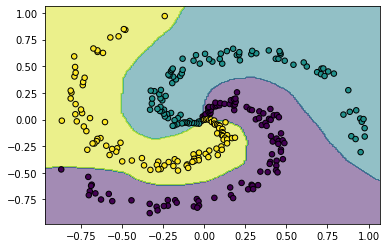

In [15]:
def decision_boundary(model, x1, x2, y, xmargin=.1, ymargin=.1, precision=0.01, tensor=True):
    x1_min, x1_max = x1.min() - xmargin, x1.max() + xmargin
    x2_min, x2_max = x2.min() - ymargin, x2.max() + ymargin
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, precision),
                           np.arange(x2_min, x2_max, precision))
    

    X = np.concatenate([xx1.reshape(-1, 1), xx2.reshape(-1, 1)], axis=1)
        
    h = model(X)
    h = h.argmax(1)
    h = h.reshape(xx1.shape)
    plt.contourf(xx1, xx2, h, alpha=0.5)
    plt.scatter(x1, x2, c=y, s=30, edgecolor='k')
    
decision_boundary(net.forward, X[:,0], X[:,1], y)

이곳을 방문해보세요. 신경망 학습을 시각적으로 보여줍니다.

- https://playground.tensorflow.org/